# 地理データの可視化
データの中には、地理情報を含むものが多くあります。

Pandasのデータフレームに地理情報を追加GeoPandasを使って、オープンデータを地図上にプロットしてみましょう。

## 準備
Colaboratoryには、GeoPandasはインストールされていないので、以下の手順でインストールします。残念ながらgplt.webmapが動かないので、foliumを使って地図を表示します。

topojsonのインストールには、npmが必要なのですが、nodeの機能に依存しているため、nodeをインストールしました。

```
E: Unable to locate package node
```
のエラーはtopojson関連のコマンドを利用するには問題ありません。



In [0]:
%%bash
apt-get install -y libproj-dev proj-data proj-bin libgeos-dev >/dev/null
pip install geopandas geoplot topojson folium geopy >/dev/null

In [3]:
%%bash
# nodeのインストールに失敗のエラーがでますが、目的のnpmはインストールできています。
apt-get install -y node npm >/dev/null
npm install -g topojson shapefile >/dev/null
mkdir Data

E: Unable to locate package node
npm WARN deprecated topojson@3.0.2: Use topojson-client, topojson-server or topojson-simplify directly.
npm WARN deprecated text-encoding@0.6.4: no longer maintained
mkdir: cannot create directory ‘Data’: File exists


## 必要なライブラリのインポート
最初に、必要なライブラリをインポートします。

In [4]:
# 必要なライブラリのインポート
import json
import csv
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import topojson
import pyproj
import matplotlib.pyplot as plt
%matplotlib inline

## 市町村行政区域のシェープファイルの取得
地理データの基本になるのは、市町村行政地区境界図です。
国土地理院の提供するシェープファイルは大きく、foliumがうまく動きません。

そこで、ここでは
<a href="https://sites.google.com/site/rbookvisjp/">全国市区町村行政区域シェープファイル</a>
からシェープファイルをダウンロードして、使用します。

国土地理院もURLで指定できるサイトを提供してくれると、貴重なデータの利活用ができると思います。

In [5]:
%%bash
cd Data
# シェープファイルのダウンロードと解凍
wget https://sites.google.com/site/rbookvisjp/home/japan_rvis_h25.zip
unzip japan_rvis_h25.zip
ls

Archive:  japan_rvis_h25.zip


--2019-12-30 21:50:34--  https://sites.google.com/site/rbookvisjp/home/japan_rvis_h25.zip
Resolving sites.google.com... 172.217.25.206
Connecting to sites.google.com|172.217.25.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://sites.google.com/site/rbookvisjp/home/japan_rvis_h25.zip?attredirects=0 [following]
--2019-12-30 21:50:35--  https://sites.google.com/site/rbookvisjp/home/japan_rvis_h25.zip?attredirects=0
Reusing existing connection to sites.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://33a679fd-a-62cb3a1a-s-sites.googlegroups.com/site/rbookvisjp/home/japan_rvis_h25.zip?attachauth=ANoY7crUzBQDf3l7YueShhwFM6-VOFslU7u0TJHEV9-LPlXA7ZYUpOU0lGM5-vgXpUH0NsqjITykOj5qWMLBou2mUWZoXSKUjT-R_v3kPi5V35mG86KlpAkgP0d9GRbFleW7CjCJkBlsy4YFbPh29jIT0FJhMw16VRVtK865VeF46HTg5fe_bhoNKobubq5JhDXyfV3I6yR1hNkVs9C_jbhAoXuACn1S6HLF_QU1VWhfBcdByv6wq-4%3D&attredirects=0 [following]
--2019-12-30 21:50:35-- 

CalledProcessError: Command 'b'cd Data\n# \xe3\x82\xb7\xe3\x82\xa7\xe3\x83\xbc\xe3\x83\x97\xe3\x83\x95\xe3\x82\xa1\xe3\x82\xa4\xe3\x83\xab\xe3\x81\xae\xe3\x83\x80\xe3\x82\xa6\xe3\x83\xb3\xe3\x83\xad\xe3\x83\xbc\xe3\x83\x89\xe3\x81\xa8\xe8\xa7\xa3\xe5\x87\x8d\nwget https://sites.google.com/site/rbookvisjp/home/japan_rvis_h25.zip\nunzip japan_rvis_h25.zip\nls\n'' returned non-zero exit status 1.

In [6]:
%%bash
cd Data
# シェープファイルをtopojson形式に変換して圧縮する
# シェープファイル名
export SHAPFILE="japan_rvis_h25.shp"
# 設定
export TARGET="boundaries"
export COMPRESS="0.05"

shp2json --encoding "Shift-JIS" $SHAPFILE > $TARGET.geojson
geo2topo -q 1e6 $TARGET=$TARGET.geojson | toposimplify -P "$COMPRESS" -f > $TARGET.topojson
ls -l

total 233192
drwxr-xr-x  6 take  staff       192 12 29 09:30 SDDSWS5436
-rw-r--r--@ 1 take  staff    134048 12 29 09:08 SDDSWS5436.zip
-rw-r--r--@ 1 take  staff    164817 12 29 09:08 SDDSWS5437.zip
-rw-r--r--@ 1 take  staff     60934 12 29 09:08 SDDSWS5536.zip
-rw-r--r--@ 1 take  staff     98303 12 29 09:08 SDDSWS5537.zip
-rw-r--r--  1 take  staff  57404736 12 30 21:50 boundaries.geojson
-rw-r--r--  1 take  staff   3080090 12 30 21:50 boundaries.topojson
-rw-r--r--  1 take  staff    259642  9  5  2013 japan_rvis_h25.dbf
-rw-r--r--  1 take  staff  24270216  9  5  2013 japan_rvis_h25.shp
-rw-r--r--  1 take  staff     15356  9  5  2013 japan_rvis_h25.shx
-rw-r--r--@ 1 take  staff  16591182  9  6  2013 japan_rvis_h25.zip
-rw-r--r--@ 1 take  staff  16591182  9  6  2013 japan_rvis_h25.zip.1


equivalent --planar-area 0.000016773876972914566


## 市町村行政地区境界
市町村行政地区シェープファイルからtopoJSON形式に変換できたので、GeoPandasのread_file関数で読み込みます。

読み込んだデータフレームには、座標系を示すCRSがセットされていないので、世界座標系（EPSG:432)をセットします。

読み込んだデータの先頭を出力してみます。
KEN, SIKUCHOSONに県名と市町村名がセットされていることが分かります。

In [7]:
# 市町村行政区域シェープファイルを読み込む
boundariesGdf =  gpd.read_file("Data/boundaries.topojson")
boundariesGdf.crs = {'init' :'epsg:4326'}
boundariesGdf.head()

,id,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,JCODE,P_NUM,H_NUM,geometry
0,None,北海道,None,None,札幌市,中央区,01101,220189.0,120596.0,"POLYGON ((141.38964 43.06859, 141.38703 43.067..."
1,None,北海道,None,None,札幌市,北区,01102,278781.0,127291.0,"POLYGON ((141.40535 43.18950, 141.40840 43.183..."
2,None,北海道,None,None,札幌市,東区,01103,255873.0,118804.0,"POLYGON ((141.44939 43.16263, 141.44693 43.155..."
3,None,北海道,None,None,札幌市,白石区,01104,204259.0,100343.0,"POLYGON ((141.47345 43.09611, 141.45060 43.064..."
4,None,北海道,None,None,札幌市,豊平区,01105,212118.0,107084.0,"POLYGON ((141.43408 43.02609, 141.42327 43.009..."


地理情報の確認のため、plot関数で地理情報をプロットしてみます。


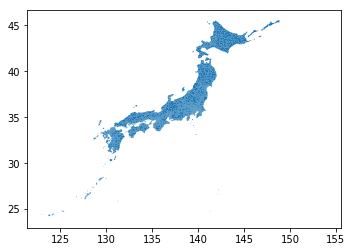

In [8]:
boundariesGdf.plot()
plt.show()

### 富山県の市町村行政境界を抽出
boundariesGdfから富山県の地区町村を抽出します。

KEN列が「富山県」のものを取り出し、toyamaGdfとします。
抽出されたデータの先頭とプロット出力を以下に示します。

このように簡単にデータの抽出とプロットができることころが、GeoPandasの優れたところです。

In [9]:
# foliumで全国を表示するには、メモリが足りないみたいなので、富山県を取り出す
toyamaGdf = boundariesGdf[boundariesGdf['KEN'] == '富山県']

toyamaGdf.head()

,id,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,JCODE,P_NUM,H_NUM,geometry
817,None,富山県,None,None,None,富山市,16201,421953.0,158833.0,"POLYGON ((137.31601 36.75855, 137.31583 36.756..."
818,None,富山県,None,None,None,高岡市,16202,176061.0,61897.0,"MULTIPOLYGON (((137.01675 36.82938, 137.04458 ..."
819,None,富山県,None,None,None,魚津市,16204,44959.0,15873.0,"POLYGON ((137.47721 36.83448, 137.50525 36.824..."
820,None,富山県,None,None,None,氷見市,16205,51726.0,16342.0,"MULTIPOLYGON (((136.98589 36.96517, 136.99626 ..."
821,None,富山県,None,None,None,滑川市,16206,33676.0,11284.0,"POLYGON ((137.31601 36.75855, 137.33350 36.762..."


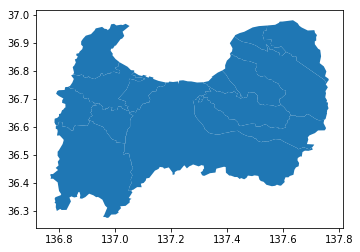

In [10]:
toyamaGdf.plot()
plt.show()

## 市町村データとの結合
市町村のオープンデータを地理情報と一緒に表示する方法を紹介します。

最初に富山県の市町村人口オープンデータからjinko_data001.xlsを読み込みます。

どんなデータなのか先頭を表示してみます。
最初の５行がヘッダーデータだとわかりました。

Pandasのquery機能を使って６行目から２０行までに絞り込みpopulationDfにセットします。


In [12]:
# 富山県市町村人口
toyamaPopulationDf = pd.read_excel('http://www.pref.toyama.jp/sections/1015/lib/jinko/_dat_h30/jinko_dat001.xls', header=6)

toyamaPopulationDf.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,市町村名,Unnamed: 5,総数,男,女,世帯数,当たり,１K㎡,Unnamed: 12,人口,世帯,人口.1,世帯.1,構成
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,人員,当たり *1,NaN,NaN,NaN,NaN,NaN,比
1,NaN,NaN,NaN,NaN,NaN,NaN,人,人,人,世帯,人,人,NaN,人,世帯,％,％,％
2,NaN,NaN,NaN,NaN,県 計,NaN,1050246,509458,540788,404929,2.59365,247.256,94.206602,-5647,4864,-0.534808,1.2158,100
3,NaN,NaN,NaN,NaN,市 部,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,郡 部,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
populatinDf = toyamaPopulationDf.query('5 <= index < 20')
populatinDf.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,市町村名,Unnamed: 5,総数,男,女,世帯数,当たり,１K㎡,Unnamed: 12,人口,世帯,人口.1,世帯.1,構成
5,NaN,NaN,NaN,NaN,富 山 市,NaN,417332,203791,213541,170263,2.4511,336.078,95.434132,-243,2649,-0.0581931,1.58042,39.7366
6,NaN,NaN,NaN,NaN,高 岡 市,NaN,169277,81715,87562,65385,2.58893,807.735,93.322446,-1246,235,-0.730693,0.360706,16.1178
7,NaN,NaN,NaN,NaN,魚 津 市,NaN,41874,20431,21443,16328,2.56455,208.733,95.280511,-226,305,-0.536817,1.90351,3.98707
8,NaN,NaN,NaN,NaN,氷 見 市,NaN,45791,21743,24048,16678,2.74559,198.608,90.415003,-765,189,-1.64318,1.14622,4.36003
9,NaN,NaN,NaN,NaN,滑 川 市,NaN,32494,15804,16690,12364,2.62811,594.91,94.691432,-90,230,-0.276209,1.8955,3.09394


### 行政のExcelファイルには要注意
富山県市町村人口populatinDfから市町村名と総数を抽出して、富山の市町村行政区データtoyamaGdfとマージしてみます。

マージにはPandasのmege関数を使い、キーになる列をonで指定します。
ところが、マージ結果は小矢部市しか表示されません。

一体どうしたことでしょう？

In [14]:
df = populatinDf[['市町村名', '総数']]
df.columns = ['SIKUCHOSON', 'POPULATION']
pd.merge(toyamaGdf, df, on='SIKUCHOSON')

,id,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,JCODE,P_NUM,H_NUM,geometry,POPULATION
0,None,富山県,None,None,None,小矢部市,16209,32067.0,9547.0,"MULTIPOLYGON (((136.83345 36.74307, 136.84118 ...",29394


自治体の資料は、再利用性ではなく、見た目でExcelを作るので、市町村名に空白が入っていることに気づきませんでした。

In [15]:
populatinDf['市町村名']

5     富 山 市
6     高 岡 市
7     魚 津 市
8     氷 見 市
9     滑 川 市
10    黒 部 市
11    砺 波 市
12     小矢部市
13    南 砺 市
14    射 水 市
15    舟 橋 村
16    上 市 町
17    立 山 町
18    入 善 町
19    朝 日 町
Name: 市町村名, dtype: object

Pandasのstr.replaceメソッドを使って「市町村名」列の空白を取り除きます。

In [16]:
populatinDf['市町村名'] = populatinDf['市町村名'].str.replace(' ', '')
populatinDf['市町村名']

/Users/take/anaconda2/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


5      富山市
6      高岡市
7      魚津市
8      氷見市
9      滑川市
10     黒部市
11     砺波市
12    小矢部市
13     南砺市
14     射水市
15     舟橋村
16     上市町
17     立山町
18     入善町
19     朝日町
Name: 市町村名, dtype: object

再度、マージすると期待通りの結果となりました。

In [17]:
df['SIKUCHOSON'] = df['SIKUCHOSON'].str.replace(' ', '')
gdf = pd.merge(toyamaGdf, df, on='SIKUCHOSON')
gdf.head()

/Users/take/anaconda2/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,JCODE,P_NUM,H_NUM,geometry,POPULATION
0,None,富山県,None,None,None,富山市,16201,421953.0,158833.0,"POLYGON ((137.31601 36.75855, 137.31583 36.756...",417332
1,None,富山県,None,None,None,高岡市,16202,176061.0,61897.0,"MULTIPOLYGON (((137.01675 36.82938, 137.04458 ...",169277
2,None,富山県,None,None,None,魚津市,16204,44959.0,15873.0,"POLYGON ((137.47721 36.83448, 137.50525 36.824...",41874
3,None,富山県,None,None,None,氷見市,16205,51726.0,16342.0,"MULTIPOLYGON (((136.98589 36.96517, 136.99626 ...",45791
4,None,富山県,None,None,None,滑川市,16206,33676.0,11284.0,"POLYGON ((137.31601 36.75855, 137.33350 36.762...",32494


### 人口のコロプレス図
富山の市町村人口を人口数によって塗り色を変えて表示するコロプレス図を表示してみます。

GeoPanda Plotのchoropleth関数を使い、hue='POPULATION'と人口の列を指定するだけで富山の市町村人口のコロプレス図が表示できます。

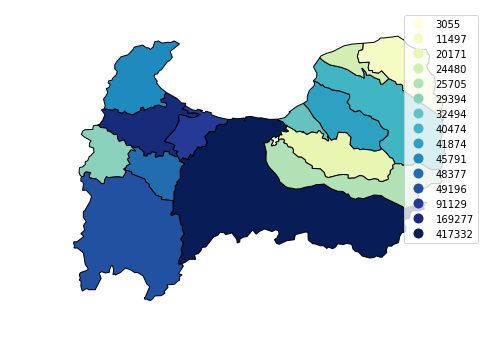

In [18]:
gplt.choropleth(gdf, hue='POPULATION', cmap='YlGnBu', legend=True)
plt.show()

## 位置情報を持つオープンデータ
オープンデータ活動が広まり、私の住む高岡市でも市の施設の情報を位置情報（緯度・経度）を提供するようになりました。

ここでは、PandasのデータからGeoPandasのデータフレームへの変換方法を紹介します。

高岡市の2018年8月のデータを使用します（高岡市のデータは古いデータを削除するため、ファイル名の日付が変わることがあります）。

読み込み時のエラーが判明したのですが、文字コードにはシフトJISではなく、CP932が使われていました。encodingに正しい文字コードを指定すれば読み込みは完了です。


In [19]:
sites = pd.read_csv('https://www.city.takaoka.toyama.jp/joho/shise/opendata/documents/shisetsu201808.csv', encoding="cp932")
sites.head()

,新番号,旧番号,ジャンル,施設名称,施設名称よみ,郵便番号,所在地,電話番号,Fax番号,開館時間,休館日,ホームページ,備考,担当課,緯度,経度
0,1,314001,市庁舎,高岡市本庁舎,たかおかしほんちょうしゃ,933-8601,富山県高岡市広小路7-50,0766-20-1111,NaN,8:30～17:15,土、日、国民の祝日、12月29日～1月3日,NaN,NaN,管財契約課,36.75487,137.025324
1,2,642001,市庁舎,戸出支所,といでししょ,939-1104,富山県高岡市戸出町2-13-4,0766-63-1250,0766-63-1239,8:30～17:15,土、日、国民の祝日、12月29日～1月3日,NaN,NaN,戸出支所,36.68180,136.980725
2,3,1900001,市庁舎,高岡市消防本部,たかおかししょうぼうほんぶ,933-0057,富山県高岡市広小路5-10,0766-22-2266,0766-22-1994,8:30～17:15,土、日、国民の祝日 、12月29日～1月3日\n,NaN,NaN,消防本部総務課,36.75450,137.023528
3,4,1900002,市庁舎,県西部消防指令センター,けんせいぶしょうぼうしれいせんたー,933-0057,富山県高岡市広小路5-10,0766-22-3131,0766-22-3498,終日,無休,NaN,NaN,消防本部総務課,36.75447,137.023581
4,5,1900003,市庁舎,高岡消防署,たかおかしょうぼうしょ,933-0057,富山県高岡市広小路5-10,0766-22-0119,0766-22-1996,終日,無休,NaN,NaN,消防本部総務課,36.75447,137.023581


GeoPandasのデータフレームへの変換は、GeoDataFrame関数にPandasのデータフレームとgeometryを渡すだけです。geometryには、データフレームの経度と緯度の列名をpoints_from_xy関数に渡します。
さらに座標系を.crsにセットします。ここでは世界座標系EPSG4326とします（もしかすると古い日本座標系のTokyoかも知れませんので、チェックが必要です）。

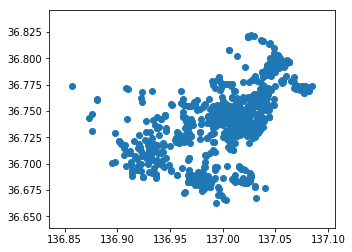

In [20]:
# PandasのDataFrameからGeoPandasのGeoDataFrameを作成
gSites  = gpd.GeoDataFrame(sites, geometry=gpd.points_from_xy(sites['経度'], sites['緯度']))
gSites.crs = {'init' :'epsg:4326'}
gSites.plot()
plt.show()

In [21]:
gSites.head()

,新番号,旧番号,ジャンル,施設名称,施設名称よみ,郵便番号,所在地,電話番号,Fax番号,開館時間,休館日,ホームページ,備考,担当課,緯度,経度,geometry
0,1,314001,市庁舎,高岡市本庁舎,たかおかしほんちょうしゃ,933-8601,富山県高岡市広小路7-50,0766-20-1111,NaN,8:30～17:15,土、日、国民の祝日、12月29日～1月3日,NaN,NaN,管財契約課,36.75487,137.025324,POINT (137.02532 36.75487)
1,2,642001,市庁舎,戸出支所,といでししょ,939-1104,富山県高岡市戸出町2-13-4,0766-63-1250,0766-63-1239,8:30～17:15,土、日、国民の祝日、12月29日～1月3日,NaN,NaN,戸出支所,36.68180,136.980725,POINT (136.98073 36.68180)
2,3,1900001,市庁舎,高岡市消防本部,たかおかししょうぼうほんぶ,933-0057,富山県高岡市広小路5-10,0766-22-2266,0766-22-1994,8:30～17:15,土、日、国民の祝日 、12月29日～1月3日\n,NaN,NaN,消防本部総務課,36.75450,137.023528,POINT (137.02353 36.75450)
3,4,1900002,市庁舎,県西部消防指令センター,けんせいぶしょうぼうしれいせんたー,933-0057,富山県高岡市広小路5-10,0766-22-3131,0766-22-3498,終日,無休,NaN,NaN,消防本部総務課,36.75447,137.023581,POINT (137.02358 36.75447)
4,5,1900003,市庁舎,高岡消防署,たかおかしょうぼうしょ,933-0057,富山県高岡市広小路5-10,0766-22-0119,0766-22-1996,終日,無休,NaN,NaN,消防本部総務課,36.75447,137.023581,POINT (137.02358 36.75447)


市町村行政地区と一緒に表示するともう少し分かりやすいですね。（本当はMap関数を使いたいのですがColaboratoryでは動きません）

市庁舎に絞り込んでプロットしてみます。

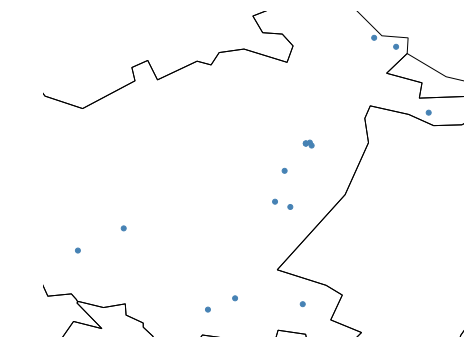

In [22]:
ax = gplt.polyplot(gdf)
gplt.pointplot(gSites[gSites['ジャンル'] == '市庁舎'], ax=ax)
plt.show()

## オープンデータ（シェープファイル）
最近では様々な地理情報がシェープファイルとして公開されるようになりました。

しかし、そのようなシェープファイルも座標系が世界標準とことなるため、他のデータを一緒に表示するとずれてしまうことがあります。例えば国土地理院の富山県の日本座標系の道路情報をプロットすると小矢部川の河口あたりで50mから100mほどずれてしまいます。
これだとせっかくの地理情報も台無しです。

座標系の変換の例題として、富山県オープンデータポータルサイトから
<a href="http://opendata.pref.toyama.jp/dataset/jisuberi_agri">地すべり危険箇所（農水省所管）</a>
をダウンロードします。
このデータは世界測地系（JGD2000）平面直角座標7系で作成されているので、そのままでは緯度・経度で表されているデータと一緒にプロットできません。

公開サイトから.shp, .shxファイルをダウンロードします。

In [23]:
%%bash
cd Data
wget http://opendata.pref.toyama.jp/files/jisuberi_agri.shp
wget http://opendata.pref.toyama.jp/files/jisuberi_agri.shx

--2019-12-30 21:52:45--  http://opendata.pref.toyama.jp/files/jisuberi_agri.shp
Resolving opendata.pref.toyama.jp... 202.213.106.6
Connecting to opendata.pref.toyama.jp|202.213.106.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54932 (54K) [application/x-qgis]
Saving to: ‘jisuberi_agri.shp’

     0K .......... .......... .......... .......... .......... 93%  213K 0s
    50K ...                                                   100% 72.9K=0.2s

2019-12-30 21:52:46 (229 KB/s) - ‘jisuberi_agri.shp’ saved [54932/54932]

--2019-12-30 21:52:46--  http://opendata.pref.toyama.jp/files/jisuberi_agri.shx
Resolving opendata.pref.toyama.jp... 202.213.106.6
Connecting to opendata.pref.toyama.jp|202.213.106.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1380 (1.3K) [application/x-qgis]
Saving to: ‘jisuberi_agri.shx’

     0K .                                                     100% 69.3M=0s

2019-12-30 21:52:46 (69.3 MB/s) - ‘jisuberi_agri.shx

まず、シェープファイルを読み込み、どのようなデータかをみます。
このファイルは単にシェープ情報を保持しているだけのファイルのようです。

In [24]:
jisueriGdf = gpd.read_file('Data/jisuberi_agri.shp')
jisueriGdf.head()

,geometry
0,"POLYGON ((30251.464 90599.618, 30252.099 90600..."
1,"POLYGON ((-7416.715 67431.465, -7507.653 67350..."
2,"POLYGON ((-7480.895 65228.221, -7513.396 65285..."
3,"POLYGON ((-6517.612 64706.594, -6450.587 64427..."
4,"POLYGON ((-6886.191 56782.919, -6834.953 56701..."


### 座標系の変換
平面直角座標7系（EPSG:2449）から世界座標系（EPSG:4326）に変換します。
pyproj.Projを使って座標系を定義し、jisueriGdfのCRSをEPSG2449にセットした後、to_crsメソッドでjisueriGdfの座標系を世界座標系（EPSG:4326）に変換します。

In [25]:
EPSG4326 = pyproj.Proj("+init=EPSG:4326")
EPSG2449 = pyproj.Proj("+init=EPSG:2449")

# 地滑り危険箇所のcsrをセット
jisueriGdf.crs = EPSG2449.crs
wgsJisureriGdf = jisueriGdf.to_crs(EPSG4326.crs)

変換した地滑り危険箇所を行政地区境界と一緒にプロットしてみます。


/Users/take/anaconda2/envs/torch_env/lib/python3.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


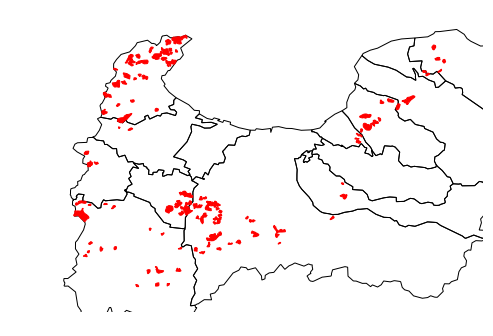

In [26]:
ax = gplt.polyplot(gdf)
gplt.polyplot(wgsJisureriGdf, ax=ax, color='red')
plt.show()

## ユーザ操作が可能な地図表示
foliumライブラリを使って、これまで使ったデータを一緒に表示してみます。

foliumを使うことで、地図の拡大・縮小、移動が自由に行え、tooltipを使ってマウスで補助情報を出力することができます。

合わせてタイル情報の切り替えの例として、国土地理院の電子国土基本図も表示します。

特にfolium.CHoropleth関数を使うとGeoPandasのデータにPandasのデータフレームのデータを簡単に重ねあわせることができます。

In [27]:
import folium.plugins

# foliumで富山県の地図と市町村行政区域を表示
# 富山県の中心座標を求める
center = toyamaGdf.geometry.unary_union.centroid

m = folium.Map(location=[center.y, center.x], tiles='cartodbpositron')
# 国土地理院の電子国土基本図
folium.raster_layers.TileLayer(
    tiles='https://cyberjapandata.gsi.go.jp/xyz/std/{z}/{x}/{y}.png',
    attr='国土地理院 電子国土基本図',
    name='電子国土基本図',
).add_to(m)

# 高岡市の市庁舎ポイント
folium.GeoJson(
    gSites[gSites['ジャンル'] == '市庁舎'], 
    name='高岡市庁舎',
    tooltip=folium.features.GeoJsonTooltip(fields=['施設名称', '所在地'])
).add_to(m)

# 富山県市町村人口コロプレス図
folium.Choropleth(
    geo_data=toyamaGdf,
    name='人口コロプレス図',
    data=populatinDf,
    columns=['市町村名', '総数'],
    key_on='feature.properties.SIKUCHOSON',
    fill_color='YlGnBu'
).add_to(m)

folium.GeoJson(wgsJisureriGdf, name='地すべり危険箇所').add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m


### おまけ
時には地名の緯度・経度が必要な時があります。
そんな時に役立つのが、Nominatimです。

geolocatorのgeocodeメソッドに検索したい住所を入力するとその場所の情報（緯度・経度を含む）が返されます。

In [28]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(timeout=10, user_agent = "dlab.berkeley.edu-workshop")
# 番地までは指定できませんが、地域の中心座標を取得できます
loc = geolocator.geocode('富山県高岡市雨晴')
loc

Location(雨晴, 国道４１５号, 高岡市, 富山県, 中部地方, 935-0037, 日本, (36.8165756, 137.0373973, 0.0))